In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
import seaborn as sns
#import re
#import regex
#from nltk.stem import PorterStemmer

In [3]:
df = pd.read_csv("included-Final.csv")

columns_to_list = ['Attribute', 'Evaluation', 'Emulator/Simulator', 'Traffic generator', 'Traffic Class', 'Controllers', 
                      'Protocol', 'Topology', 'Service Focus', 'Metrics', 'SB_Prot', 'Attackload', 
                      'Faultload', 'Classifiers']

for column in columns_to_list:
    df[column] = df[column].apply(lambda x: [] if pd.isna(x) else x.split(';'))

df['Service Focus'] = df['Service Focus'].apply(lambda x: [int(i) for i in x])

In [5]:
uc = pd.read_csv("Use_Cases.csv")
uc['Topo_struct'] = uc['Topo_struct'].apply(lambda x: [] if pd.isna(x) else x.split(';'))
uc['Main_service'] = uc['Main_service'].apply(lambda x: [] if pd.isna(x) else x.split(';'))

In [6]:
for index, row in uc.iterrows():
    for i, paper_row in df.iterrows():
        score = 0
        if paper_row["Volume"] <= row["Traffic_volume"]:
            score += 0.5
        if any(topo in row["Topo_struct"] for topo in paper_row["Topology"]) or row["Topo_struct"] == 'Any':
            score += 0.5
        if row["Topo_size"] <= paper_row["Topo_size"]:
            score += 0.5
        if row["Nodes_size"] <= paper_row["Nodes_size"]:
            score += 0.5
        if paper_row["Temporal Pattern"] == row["Traffic_bhvr"]:
            score += 0.5
        if row["UC"] in ["NV"]:
            if df["Service Focus"][i][7] == 1:
                score += 0.5
        elif row["UC"] in ["NT"]:
            if df["Service Focus"][i][1] == 1:
                score += 0.5
        else:
            score += 0.5
        df.at[i, row["UC"]] = score

In [7]:
df['Evaluat_Relev'] = df.apply(lambda row: 3 if len(row['Evaluation']) > 1 else (2 if row['Evaluation'] == 'Real Testbed' else 1), axis=1)
df['Traffic_Class_Relev'] = df.apply(lambda row: 3 if len(row['Traffic Class']) > 1 else (2 if row['Traffic Class'] == 'Network Performance Traffic' else 1), axis=1)
df['Traffic_Prot_Relev'] = df.apply(lambda row: 3 if len(row['Protocol']) > 2 else (2 if len(row['Protocol']) > 1 else 1), axis=1)
df['Traffic_Relev'] = (df['Traffic_Class_Relev'] + df['Traffic_Prot_Relev']) / 2
df['Ctrl_Relev'] = df.apply(lambda row: 3 if len(row['Controllers']) > 3 else (2 if len(row['Controllers']) > 2 else (1 if len(row['Controllers']) > 1 else 0)), axis=1)
df['Topo_Struct_Relev'] = df.apply(lambda row: 3 if len(row['Topology']) > 2 else (2 if len(row['Topology']) > 1 else 1), axis=1)
df['Topo_Sw_Relev'] = df.apply(lambda row: 3 if row['max_switches'] > row['min_switches'] else 1, axis=1)
df['Topo_Node_Relev'] = df.apply(lambda row: 3 if row['Max_nodes'] > row['Min_nodes'] else 1, axis=1)
df['Topo_Relev'] = (df['Topo_Struct_Relev'] + df['Topo_Sw_Relev'] + df['Topo_Node_Relev']) / 3
df['Relevance'] = (df['Evaluat_Relev']*2 + df['Traffic_Relev'] + df['Ctrl_Relev'] + df['Topo_Relev']) / 5



In [8]:
df['Metrics_Repr'] = df.apply(lambda row: 3 if row['Att. comp.'] == 1 and row['Svc comp.'] == 1 else (1 if row['Att. comp.'] == 1 or row['Svc comp.'] == 1 else 0), axis=1)
df['Method_Repr'] = df.apply(lambda row: 3 if row['Repr_ES'] == 1 and row['Repr_Int'] == 1 else (1 if row['Repr_ES'] == 1 or row['Repr_Int'] == 1 else 0), axis=1)
#df['Representativeness'] = (df['Metrics_Repr'] + df['Method_Repr'] + (df[['DC', 'NV', 'SDW', 'IOT', 'NT']].sum(axis=1) / 5)) / 3 + df['Controllers'].apply(len)
df['Representativeness'] = (df['Metrics_Repr'] + df['Method_Repr'] + (df[['DC', 'NV', 'SDW', 'IOT', 'NT']].sum(axis=1) / 5)) / 3

df['Repeatability'] = df.apply(lambda row: 3 if row['Demonstrable'] == 1 else (1 if row['Inferable'] == 1 or row['Verifiable'] == 1 or row['Repeat tests'] == 1 else 0), axis=1)
df_repeat = df.sort_values(by='Repeatability', ascending=False)

df['Portability'] = df.apply(lambda row: 3 if row['App_Dep']+row['Mod_Dep']+row['Hw_Dep']+row['Prot_Dep'] < 2 else (1 if row['App_Dep']+row['Mod_Dep']+row['Hw_Dep']+row['Prot_Dep'] < 4 else 0), axis=1)

df['Usability'] = df.apply(lambda row: 3 if row['Provide Tool'] == 1 else (1 if row['Documentation'] == 1 else 0), axis=1)

df['Fairness'] = df.apply(lambda row: 3 if row['Ctrl_concern']+row['Setup_concern']+row['Wkl_concern'] > 2 else (1 if row['Ctrl_concern']+row['Setup_concern']+row['Wkl_concern'] > 0 else 0), axis=1)

df['Final Score'] = df.apply(lambda row: row['Relevance']+row['Representativeness']+row['Repeatability']+row['Portability']+row['Usability']+row['Fairness'], axis=1)
df_final_score = df.sort_values(by='Final Score', ascending=False)

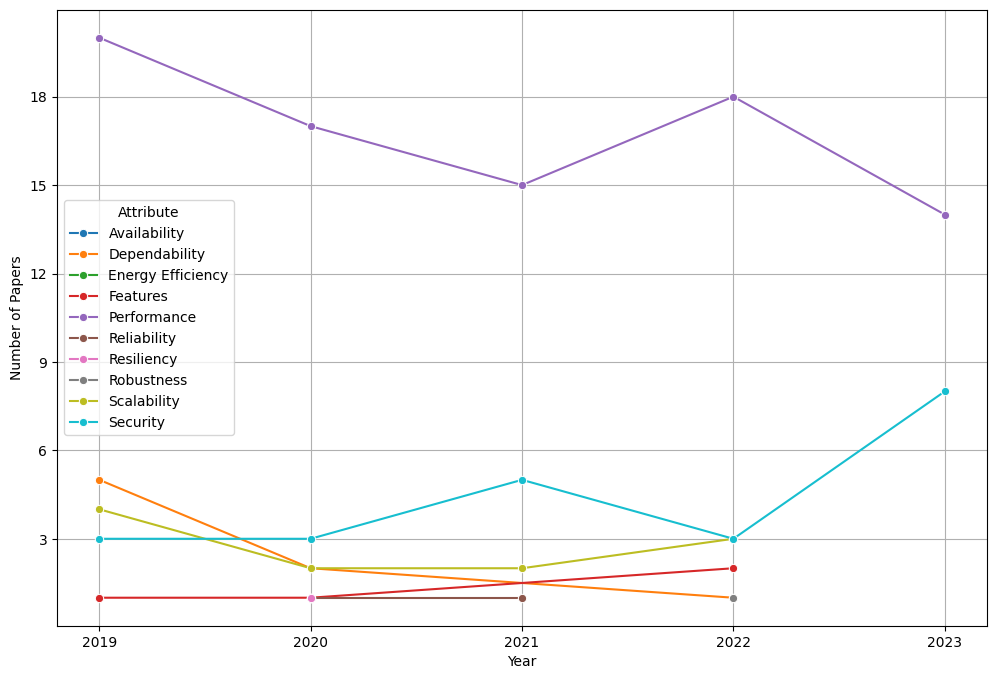

In [18]:
# Flatten the lists in the 'Attribute' column into separate rows
df_flat = df.explode('Attribute')

# Grouping the DataFrame by 'Attribute' and 'Year' and counting the number of papers
paper_counts = df_flat.groupby(['Attribute', 'Year']).size().reset_index(name='Count')

# Plotting the line chart
plt.figure(figsize=(12, 8))
sns.lineplot(data=paper_counts, x='Year', y='Count', hue='Attribute', marker='o')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Number of Papers')
#plt.title('Number of Papers for Each Attribute Over the Years')

# Set integer formatting for x-axis and y-axis ticks
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Displaying the chart
plt.legend(title='Attribute')
plt.grid(True)
plt.show()


In [9]:
def plot_attribute_percentage(df, column_name,title,xlabel):
    df[column_name] = df[column_name].apply(lambda x: [item.upper() for item in x])
    # Flatten the lists in the specified column
    attributes = [item for sublist in df[column_name] for item in sublist]
    
    # Calculate the frequency of each attribute
    attribute_counts = pd.Series(attributes).value_counts()
    
    # Convert counts to percentages
    attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100
    
    # Create a bar plot
    plt.figure(figsize=(20, 12))
    attribute_percentages.plot(kind='bar', color='skyblue',fontsize=16)
    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=16)
    plt.ylabel('Percentage of papers',fontsize=16)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_attribute_percentage(df, 'Attribute')
def plot_radar_chart(values, labels, title, ylim=None):
    # Number of variables/dimensions
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Make the plot close to a circle
    values += values[:1]
    angles += angles[:1]

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

    # Draw one axe per variable + add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw ylabels
    ax.set_rlabel_position(0)
    if ylim:
        plt.yticks(ylim, [str(y) for y in ylim], color="grey", size=7, fontsize=12)
        plt.ylim(0, max(ylim))
    else:
        plt.ylim(0, max(values) * 1.1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels,fontsize=14)

    # Show the radar chart
    plt.title(title)
    plt.show()


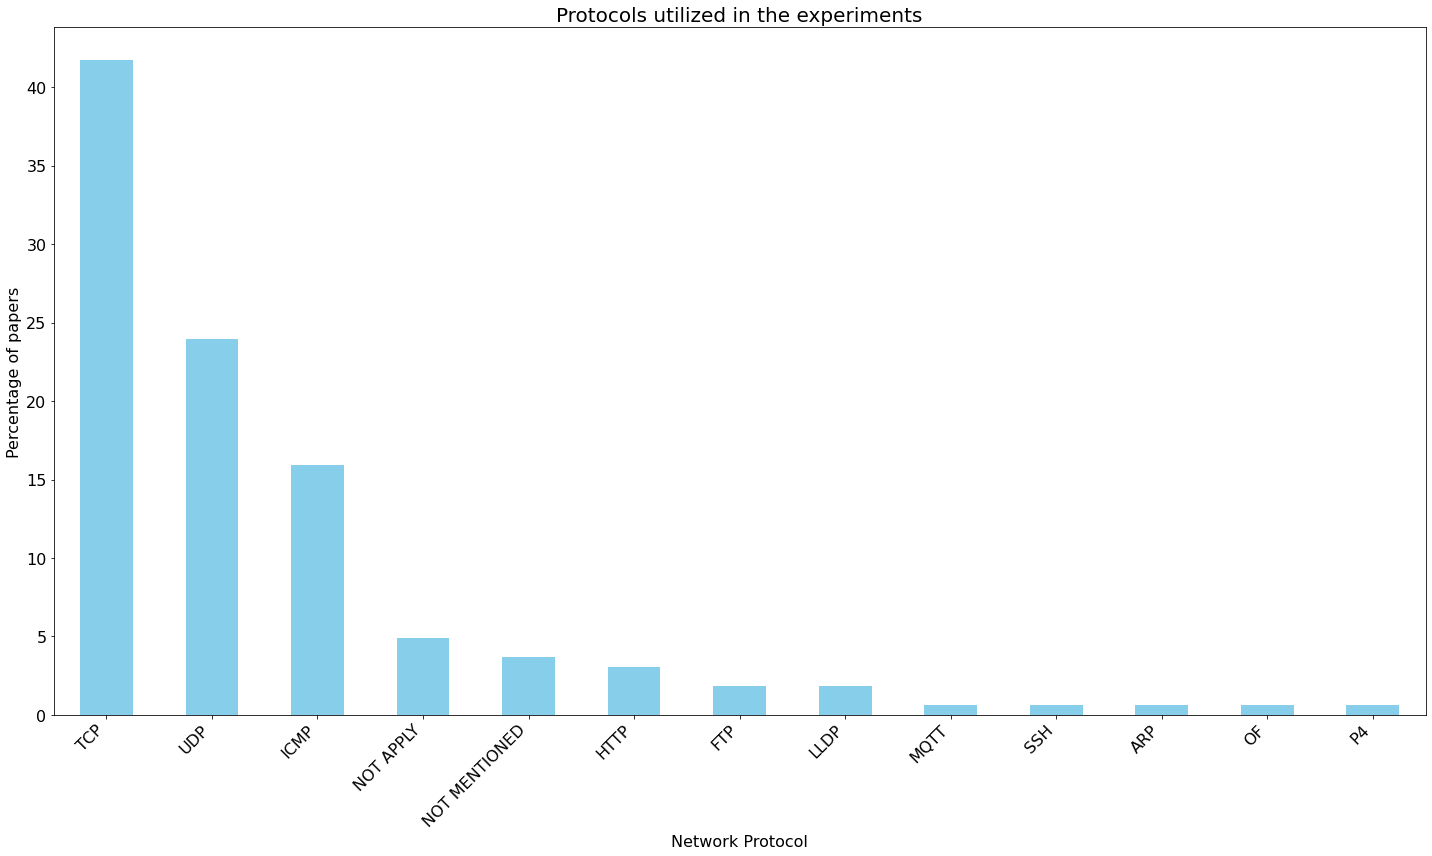

In [13]:
plot_attribute_percentage(df,'Protocol','Protocols utilized in the experiments','Network Protocol')

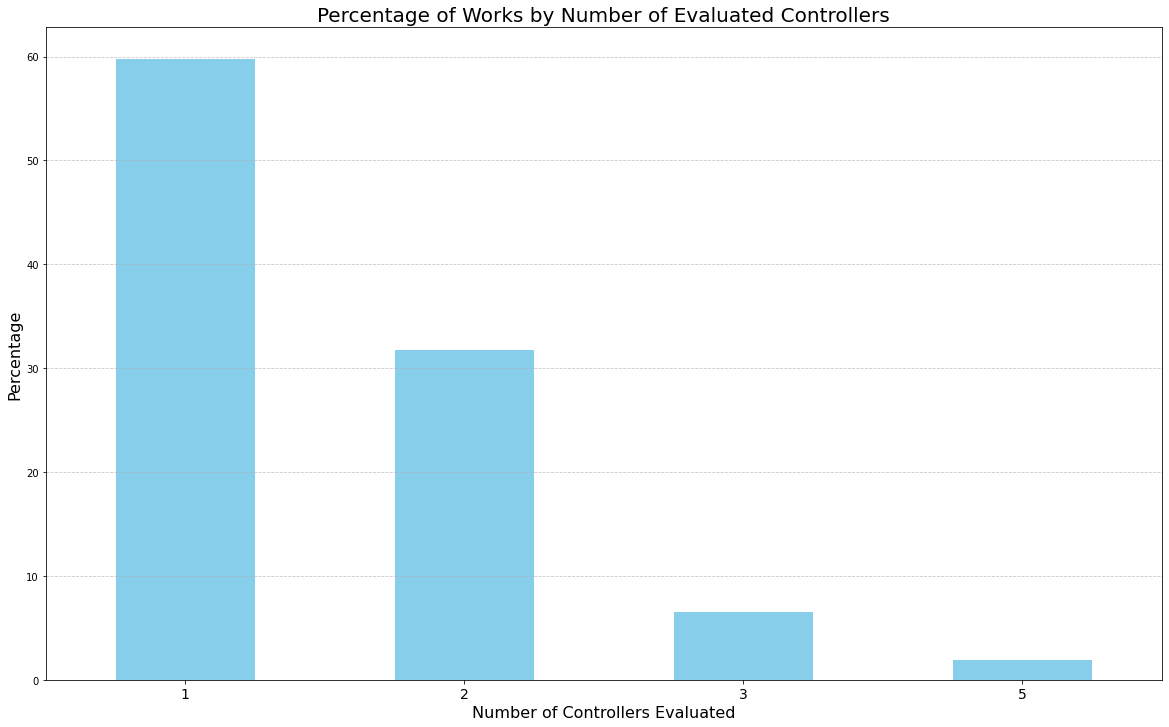

In [15]:
df['Num_controllers_evaluated'] = df['Protocol'].apply(len)

# Calculate the percentage of works containing each number of evaluated controllers
percentages = df['Num_controllers_evaluated'].value_counts(normalize=True) * 100

# Plot the results as a bar chart
plt.figure(figsize=(20, 12))
percentages.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Controllers Evaluated',fontsize=16)
plt.ylabel('Percentage',fontsize=16)
plt.title('Percentage of Works by Number of Evaluated Controllers',fontsize=20)
plt.xticks(rotation=0,fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

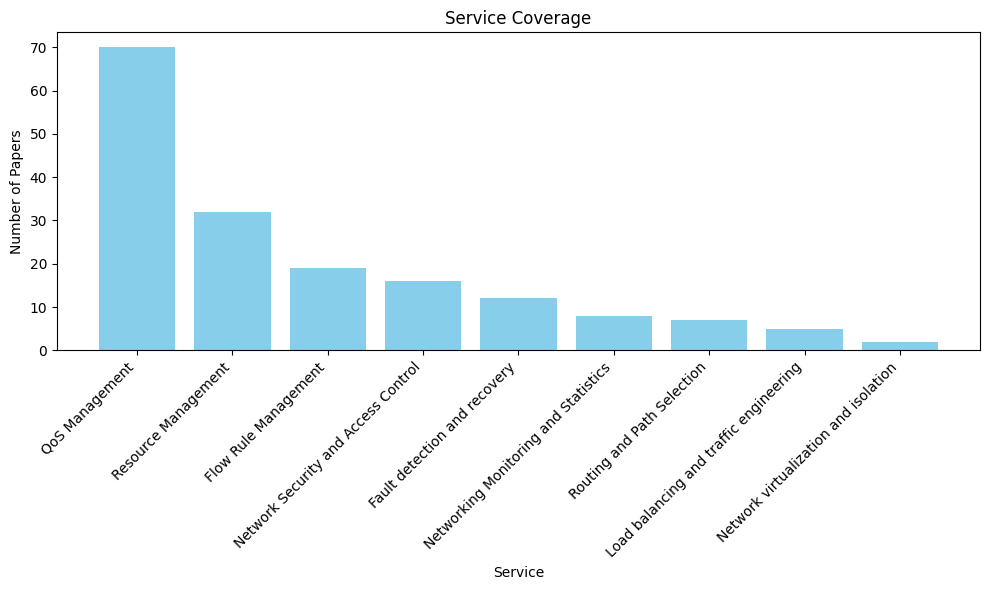

In [19]:
service_labels = ['Resource Management', 'Networking Monitoring and Statistics', 'QoS Management',
                  'Network Security and Access Control', 'Routing and Path Selection',
                  'Load balancing and traffic engineering', 'Fault detection and recovery',
                  'Network virtualization and isolation', 'Flow Rule Management']

service_coverage = {}

for i, lbl in enumerate(service_labels):
    count = sum(sf[i] for sf in df['Service Focus'])
    service_coverage[lbl] = count

# Sorting service_coverage by values in ascending order
sorted_service_coverage = dict(sorted(service_coverage.items(), key=lambda item: item[1],reverse=True))

# Plotting the sorted service coverage
plt.figure(figsize=(10, 6))
plt.bar(sorted_service_coverage.keys(), sorted_service_coverage.values(), color='skyblue')
plt.title('Service Coverage')
plt.xlabel('Service')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

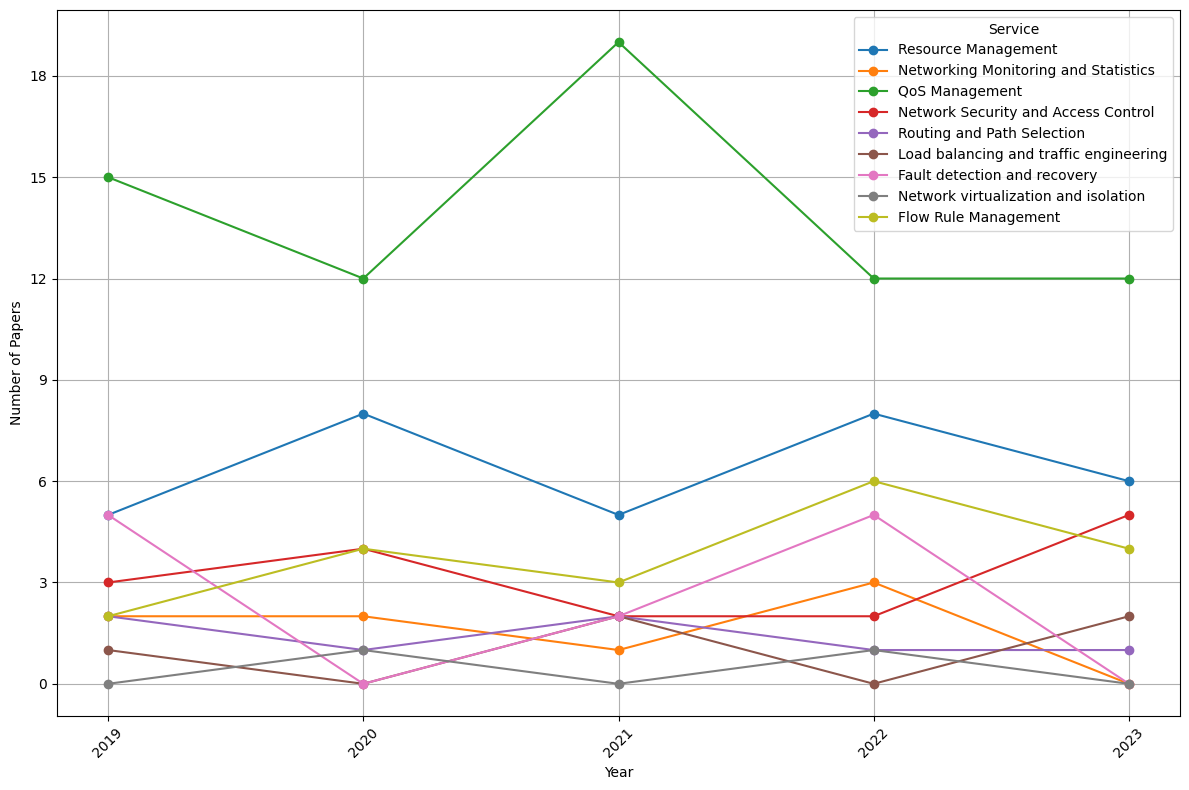

In [38]:
service_coverage_by_year = {}

for year in df['Year'].unique():
    service_coverage = {label: 0 for label in service_labels}
    for idx, row in df[df['Year'] == year].iterrows():
        for i, count in enumerate(row['Service Focus']):
            service_coverage[service_labels[i]] += count
    service_coverage_by_year[year] = service_coverage

# Plotting the service coverage by year
plt.figure(figsize=(12, 8))
for service_label in service_labels:
    plt.plot(sorted(service_coverage_by_year.keys()), [d[service_label] for d in service_coverage_by_year.values()], marker='o', label=service_label)
# Set integer formatting for x-axis and y-axis ticks
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Number of Papers')
#plt.title('Service Coverage by Year')
plt.legend(title='Service')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
layer_coverage

{'AL': 26, 'NBI': 2, 'EWBI': 5, 'Core': 102, 'SBI': 7, 'DP': 25}

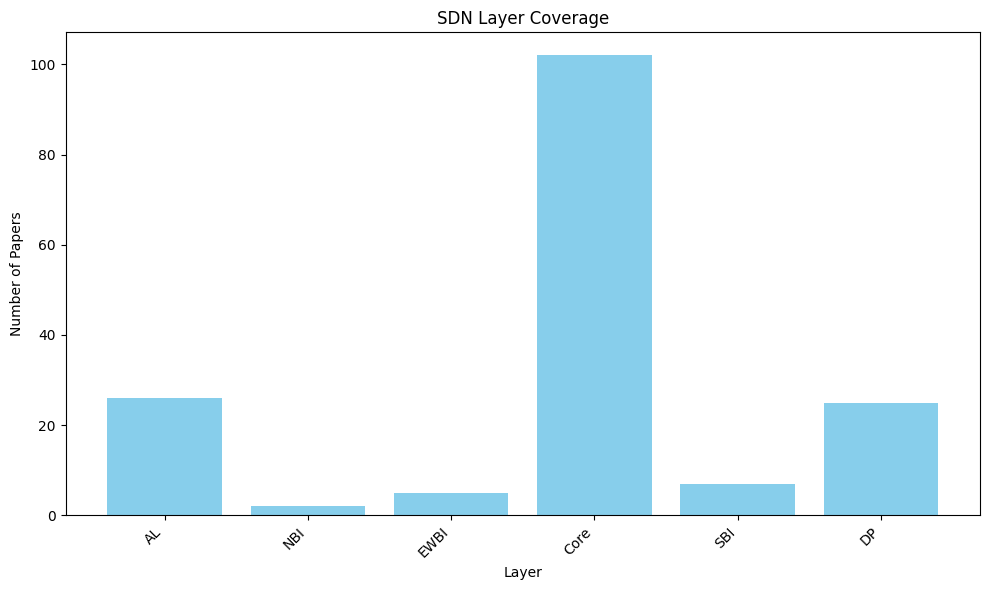

In [29]:
layer_labels = ['AL','NBI','EWBI','Core','SBI','DP']

layer_coverage = {}

for lbl in layer_labels:
    count = sum(sf for sf in df[lbl])
    layer_coverage[lbl] = count

# Plotting the sorted service coverage
plt.figure(figsize=(10, 6))
plt.bar(layer_coverage.keys(), layer_coverage.values(), color='skyblue')
plt.title('SDN Layer Coverage')
plt.xlabel('Layer')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

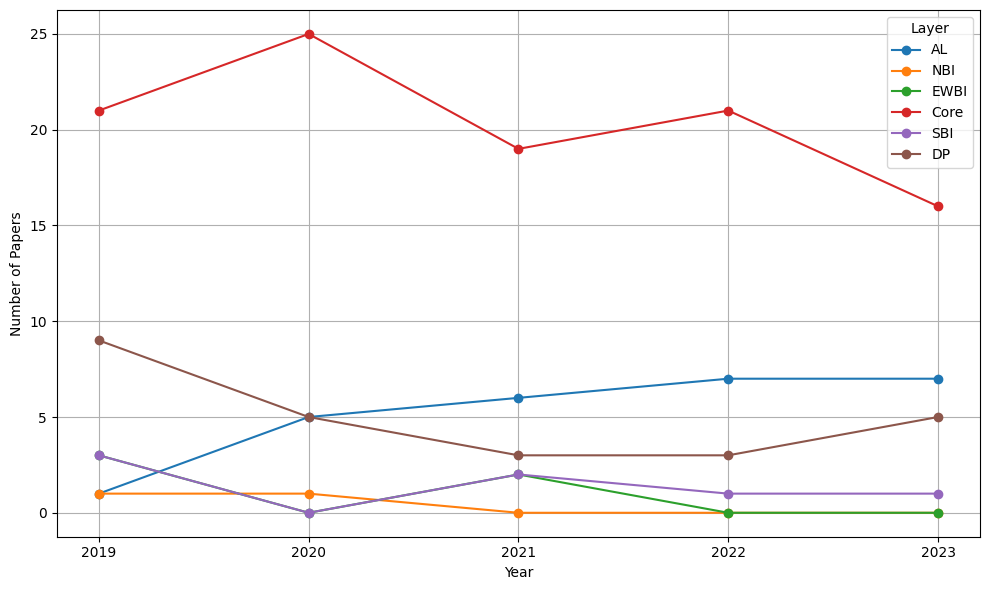

In [34]:
# Get unique years
years = df['Year'].unique()

# Initialize the layer coverage dictionary
layer_coverage = {year: {} for year in years}

# Iterate over each year
for year in years:
    # Filter the dataframe for the current year
    df_year = df[df['Year'] == year]
    # Iterate over each layer label
    for lbl in layer_labels:
        # Count the occurrences of the layer label for the current year
        count = df_year[lbl].sum()
        # Add the count to the layer coverage dictionary for the current year
        layer_coverage[year][lbl] = count
years = sorted(layer_coverage.keys())

# Plotting the layer coverage for each year
plt.figure(figsize=(10, 6))
for layer in layer_labels:
    layer_counts = [layer_coverage[year].get(layer, 0) for year in years]
    plt.plot(years, layer_counts, marker='o', label=layer)

#plt.title('SDN Layer Coverage (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(years)
plt.legend(title='Layer')
plt.grid(True)
plt.tight_layout()
plt.show()

In [149]:
# Initialize an empty list with dictionaries
word_counts = [collections.Counter() for _ in range(9)]

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    # Split the string by ','
    words = row["Metrics"]
    # Update the word count for each position
    for i in range(9):
        # Skip empty strings and out-of-range indices
        if i < len(words) and words[i]:
            # Count the occurrences of words in the current position
            word_count = collections.Counter(words[i].split(','))
            # Update the dictionary for the current position
            word_counts[i].update(word_count)

#AINDA PRECISA AJUSTAR SPLIT E AVALIAR SE ESTÁ REPRESENTATIVO

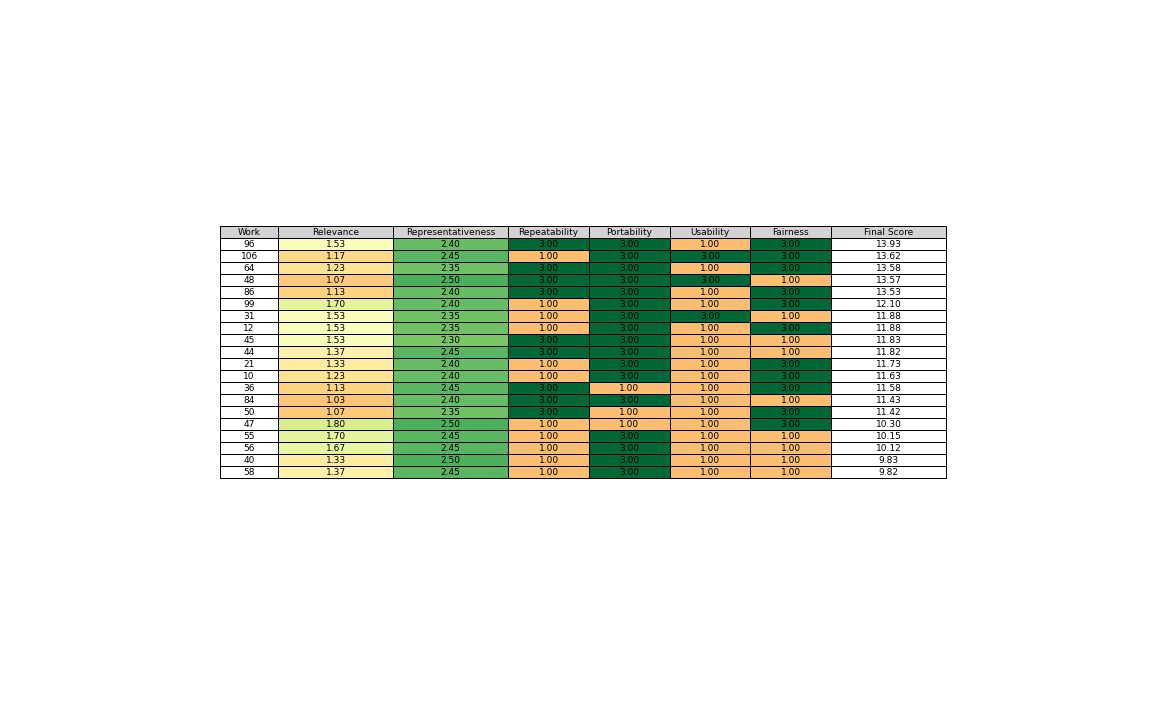

In [44]:
fs = df.sort_values(by='Final Score', ascending=False)  # Sort by Final Score
columns = ["Relevance","Representativeness", "Repeatability", "Portability", "Usability", "Fairness", "Final Score"]
fs = fs.head(20)[columns]
fs.insert(0, 'Work', fs.index)
fs['Final Score'] = fs['Final Score'].apply(lambda x: '{:.2f}'.format(x))

# Create a figure and a grid to place the table
fig, ax = plt.subplots(figsize=(20, 12))
ax.axis('tight')
ax.axis('off')
col_widths = [0.05, 0.1, 0.1, 0.07, 0.07, 0.07, 0.07, 0.1]
ax.set_position([0.1, 0.1, 0.8, 0.8])  # Adjust position and size as needed
# Convert dataframe to table
table = ax.table(cellText=fs.values,
                 colLabels=fs.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=['lightgray'] * len(fs.columns),  # Default color for columns
                 colWidths=col_widths,
                 fontsize=16)  # Adjust column width as needed

# Format 'Work' column values as integers and exclude from colorization
for i in range(len(fs)):
    table._cells[(i + 1, 0)]._text.set_text(int(fs.iloc[i, 0]))  # Format as integer
    table._cells[(i + 1, 0)].set_facecolor('white')  # Exclude from colorization

norm = Normalize(vmin=0.0, vmax=3.0)

# Define color map for gradient background
cmap = plt.cm.RdYlGn

# Color the cells of each column based on their values
for j in range(1, len(fs.columns) - 1):  # Exclude 'Work' and 'Final Score' columns
    cell_values = fs.iloc[:, j]
    norm_values = norm(cell_values)
    colors = [cmap(val) for val in norm_values]
    for i in range(len(fs)):
        table._cells[(i + 1, j)].set_facecolor(colors[i])
        table._cells[(i + 1, j)]._text.set_text('{:.2f}'.format(cell_values.iloc[i]))

plt.show()


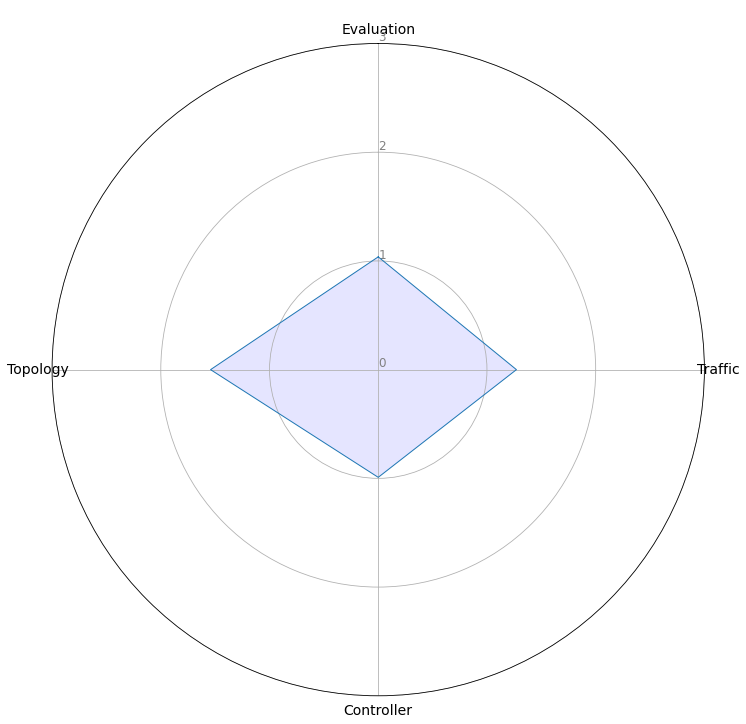

In [16]:
#Evaluat_Relev	Traffic_Relev	Ctrl_Relev	Topo_Relev
values = [df['Evaluat_Relev'].sum()/len(df),df['Traffic_Relev'].sum()/len(df), df['Ctrl_Relev'].sum()/len(df), df['Topo_Relev'].sum()/len(df)]
labels = ['Evaluation','Traffic','Controller', 'Topology']
ylim = [0, 1, 2, 3]
plot_radar_chart(values, labels, " ", ylim)

In [282]:
df[['Ctrl_concern','Setup_concern','Wkl_concern','Fairness']].to_csv("fairness.csv")